# Guannan Shen BIOS 7718 Bio Image  HW2

In [557]:
# modules
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import math

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import LineModelND, ransac

import scipy.ndimage as ndi
from skimage.morphology import watershed
from skimage.filters import sobel

# current working directory
import os
os.getcwd()

'/home/guanshim/Documents/image_data/bio_image'

## RANdom SAmple Consensus (RANSAC)

### Basic Theory
RANSAC is a general framework for model fitting when there are outliers. Here we are going to apply this method to fit 3D lines with present of outliers.  

In this case, the RANSAC algorithm works as (from skimage.measure):  
1. 2 points (n) are required to fit the model. The model here is total least squares estimator for 3-dimensional lines.  
2. The number of iterations required k. And we know we have 30 out of 130, 30 out of 150 and 20 out of 150 inliers. Thus, the k is decided by $(1 - (1 - \epsilon)^n)^k <= 0.01$ where $\epsilon$ is the proportion of outliers. 
3. Define the threshold t to identify a point that fits well. 
4. For k iterations, 
  -  each time, draw 2 points from data, randomly and uniformly.
  -  Fit a 3D line of these 2 points.
  -  For each data points beside these 2, test the distance from the point to the line against t, threshold. Get well-fitted data points.
  -  Another parameter, which is not user-defined in this function, d, is the cutoff for the number of good fit data. If there are d or more points close to the fitted line, this fitted line will be added to the collection of good fits.
5. From the collection of good fits, choose the best one based on the fitting error. 

### Fit one line

In [558]:
# generate data
np.random.seed(1932)
# number of inliers
n = 30
m = 20

# inliers 1
A1 = np.repeat(np.linspace(0.4,0.69, n), 2)
xy1 = np.reshape(A1, (-1, 2))
def getz1(xy):
    return (1 - xy[0]- 2*xy[1])/3

z1 = np.apply_along_axis( getz1, axis=1, arr=xy1 ).reshape(-1, 1)
xyz1 = np.hstack((xy1, z1))
# noise
mean = [0,0,0]
cov = (0.01**2)*np.identity(3)
noise1 = np.random.multivariate_normal(mean, cov, n)
# final inlier
xyz_n = xyz1 + noise1


# inliers 2 
A2 = np.repeat(np.linspace(0.4,0.59, m), 2)
xy2 = np.reshape(A2, (-1, 2))
def getz2(xy):
    return (1 - xy[0]- xy[1])

z2 = np.apply_along_axis( getz2, axis=1, arr=xy2 ).reshape(-1, 1)
xyz2 = np.hstack((xy2, z2))
# noise
noise2 = np.random.multivariate_normal(mean, cov, m)
xyz_m = xyz2 + noise2

# outliers 
n_o = 100
out = np.random.uniform(low = 0,high = 1,size=(n_o, 3))

# get data 1
data1 = np.vstack( (xyz_n, out))
# get data 2
data2 = np.vstack( (data1, xyz_m))

# solve k base = (1 - (1 - 130/150)**3 )
# (1 - (1 - 130/150)**3 )**1941
# (1 - (1 - 100/130)**3 )**373
# (1 - (1 - 120/150)**3 )**575

To have a hint of the threshold. 

In [559]:
# distance of point to a plane
# a*x + b*y + c*y + d = 0
def shortest_distance_1(out):  
    a,b,c,d = [1,2,3,-1]
    x1, y1, z1 = out
    d = abs((a * x1 + b * y1 + c * z1 + d))  
    e = (math.sqrt(a * a + b * b + c * c)) 
    return d/e 
d = np.apply_along_axis(shortest_distance_1, axis=1, arr = out ).reshape(-1, 1)
print(d.min())

# def shortest_distance_2(out):  
#     a,b,c,d = [1,1,1,-1]
#     x1, y1, z1 = out
#     d = abs((a * x1 + b * y1 + c * z1 + d))  
#     e = (math.sqrt(a * a + b * b + c * c)) 
#     return d/e 


0.006752069165626098


In [560]:
np.random.seed(1932)
model_robust, inliers = ransac(data1, LineModelND, min_samples=2, residual_threshold=0.03, max_trials=373)
print(sum(inliers[:30]))
print(sum(inliers[30:130]))

30
0


In [561]:
ground_truth1 = np.concatenate( (np.repeat(True, n), np.repeat(False, n_o)) )
print(ground_truth1.shape)
print( sum(ground_truth1) )
outliers = ground_truth1 == False

(130,)
30


In [562]:
# model_robust.predict()
# model_robust.predict( [:,2] )
predict = model_robust.predict( xyz_n[:,0] )

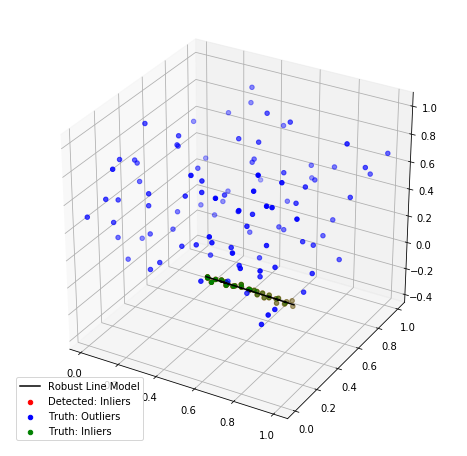

In [563]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data1[inliers][:, 0], data1[inliers][:, 1], data1[inliers][:, 2], c='r', marker='o', label='Detected: Inliers')
ax.scatter(data1[outliers][:, 0], data1[outliers][:, 1],data1[outliers][:, 2], c='b', marker='o', label='Truth: Outliers')
ax.scatter(data1[ground_truth1][:, 0], data1[ground_truth1][:, 1], data1[ground_truth1][:, 2], c='g', marker='o', label='Truth: Inliers')
ax.plot(predict[:, 0], predict[:, 1], predict[:, 2], '-k', label='Robust Line Model')
ax.legend(loc='lower left')
plt.show()

30 true inliers are detected. 0 outliers are classified as inliers. 

### Fit two lines

In [564]:
# first fit 30 inliers
np.random.seed(1932)
model_robust1, inliers1 = ransac(data2, LineModelND, min_samples=2, residual_threshold=0.03, max_trials=575)
print(sum(inliers1[:30]))
print(sum(inliers1[30:130]))
print(sum(inliers1[130:150]))

30
0
0


In [565]:
np.random.seed(1932)
model_robust2, inliers2 = ransac(data2, LineModelND, min_samples=2, residual_threshold=0.0278, max_trials=1941)
print(sum(inliers2[:30]))
print(sum(inliers2[30:130]))
print(sum(inliers2[130:150]))

9
1
20


In [566]:
# prediction
predict1 = model_robust1.predict( xyz_n[:, 0] )
predict2 = model_robust2.predict( xyz_m[:, 0] )


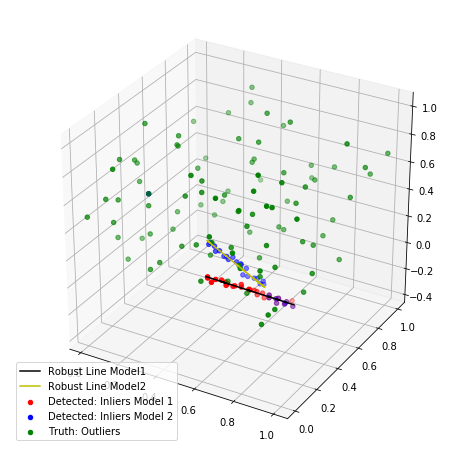

In [567]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data2[inliers1][:, 0], data2[inliers1][:, 1], data2[inliers1][:, 2], c='r', marker='o', label='Detected: Inliers Model 1')
ax.scatter(data2[inliers2][:, 0], data2[inliers2][:, 1], data2[inliers2][:, 2], c='b', marker='o', label='Detected: Inliers Model 2')
ax.scatter(data1[outliers][:, 0], data1[outliers][:, 1],data1[outliers][:, 2], c='g', marker='o', label='Truth: Outliers')
ax.plot(predict1[:, 0], predict1[:, 1], predict1[:, 2], '-k', label='Robust Line Model1')
ax.plot(predict2[:, 0], predict2[:, 1], predict2[:, 2], '-y', label='Robust Line Model2')
ax.legend(loc='lower left')
plt.show()

## Object detection using Hough transform.

### Apply Hough transform to circle detection, particularly for car wheels detection

#### Basic Theory
**Hough transform** is used to link edge points. In this case, we want to find circle edges. In general, Hough transform is the transformation from the image space to the parameter space. Given the equation of circle if the radius is unknown:
$$(a - x_0)^2 + (b - y_0)^2 = r^2$$
All cirles in the image space passing through the point $(x_0, y_0)$ correspond to a cone surface in the abr-parameter space. For all the points in the image space on the same circle, their associated cones intersect at a common point $(a_0, b_0, r_0)$ in the parameter space.  
Thus, we need a three dimensional accumulator.  
And the circle detection is to find the local maxima in the parameter space.  

**Bilateral Filtering**  
The bilateral filter, *cv2.bilateralFilter()*, which was defined for, and is highly effective at noise removal while preserving edges.  

**Median Filter**  
For small to moderate levels of (Gaussian) noise, the median filter is demonstrably better than Gaussian blur at **removing noise whilst preserving edges** for a given, fixed window size. However, its performance is not that much better than Gaussian blur for high levels of noise, whereas, for speckle noise and salt and pepper noise (impulsive noise), it is particularly effective. 

#### Implementation
cv2.HoughCircles() from python cv2 was used here. This function takes single channel 8-bit grayscale image. The output is a vector of $(x, y, radius)$. 

In [568]:
# This image is greyscale
# 0 means read as greyscale
img = cv2.imread("P2_car.png",0)
print(img.shape)

(306, 466)


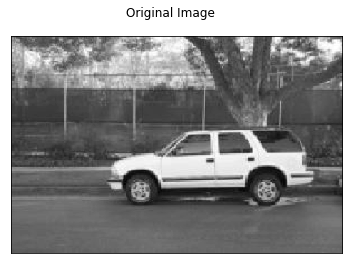

In [569]:
# show 
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.suptitle('Original Image')
plt.show()

This is to provide hints for parameters in cv2.HoughCircles().

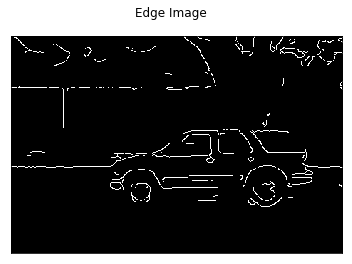

In [570]:
# gaussian filter to blur
blur = cv2.GaussianBlur(img,(7,7),0)
median = cv2.medianBlur(img,7)
# canny edge detection
edges = cv2.Canny(median, 100, 200, apertureSize = 3, L2gradient = True)

plt.imshow(edges, cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.suptitle('Edge Image')
plt.show()

In [571]:
# hough circle detection
# first int 1 means the same resolution as the input image 
# minDist is the distance between nearby circle
# param1 is the maxVal for canny detection
# param2 is the accumulator threshold
circles = cv2.HoughCircles(median,cv2.HOUGH_GRADIENT, 1, minDist = 120, param1=200,param2=20,minRadius=10,maxRadius=30)
circles = np.uint16(np.around(circles))
print(circles)

[[[356 218  15]
  [182 216  14]]]


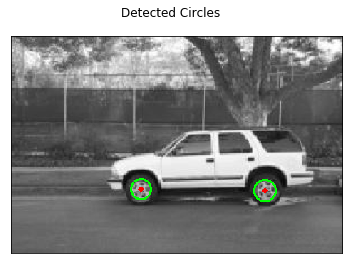

In [572]:
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(255,0,0),3)

# show image 
plt.imshow(cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.suptitle('Detected Circles')
plt.show()

### Apply Hough transform to nucleus detection

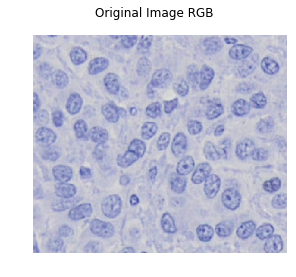

In [573]:
# show 
# This image is RGB
img = cv2.imread("P2_nuclei.png")

image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image)
plt.suptitle('Original Image RGB')
plt.show()

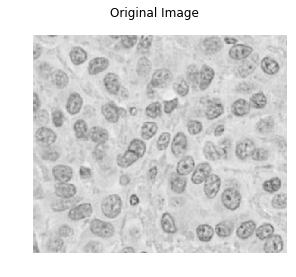

In [574]:
# grayscale
cimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(cimg, cmap = 'gray')
plt.show()

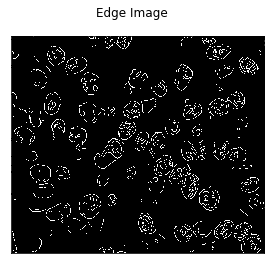

In [575]:
# gaussian filter to blur
blur = cv2.GaussianBlur(cimg,(5,5),0)
# kernel size 5
median = cv2.medianBlur(cimg,5)
# canny edge detection
edges = cv2.Canny(median, 40, 80, apertureSize = 3, L2gradient = True)

plt.imshow(edges, cmap = "gray")
plt.xticks([]), plt.yticks([]), plt.suptitle('Edge Image')
plt.show()

In [576]:
circles = cv2.HoughCircles(median,cv2.HOUGH_GRADIENT, 1, minDist = 35, param1=80,param2=10,minRadius=15,maxRadius=30)
circles = np.uint16(np.around(circles))
circles.shape[1]

75

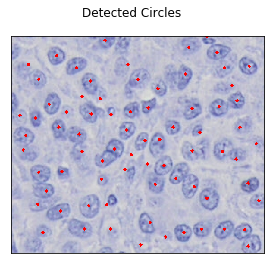

In [577]:
# This image is RGB
img = cv2.imread("P2_nuclei.png")
for i in circles[0,:]:
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)

# show image 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]), plt.suptitle('Detected Circles')
plt.show()

There are 75 nuclei detected. 

## Object segmentation using watershed transform.

### Coins Segmentation
Apply marker-controlled watershed to image segmentation for P3_coins.png. You might want to use the erosion morphology operation to find the markers. Please draw the segmented boundaries/contours on the original image and mark the contours with different colors, one per segment.

#### Watershed transform
**Watershed transform** interprets the grayscale image as topological map where intensity denotes hills or valleys. It is often applied to the gradient of the image for segmentation.  

Basically, the algorithm starts filling local maxima (isolated valleys) with different colored water (labels). As the water rises, depending on the surrounding hills (gradients), water from nearby valleys will start to merge. To avoid that, dams will be built in the locations where water merges. Keeps this process untill all the peaks are under the water. As a result, these dams are the boundaries of the segmented regions.  

Usually, this method suffers from over-segmentation due to noise and irrelevant details. Thus, in practice, **marker-based watershed** algorithm is always used. Particularly, both internal markers, associated with objects of interest and external markers, associated with image background are used.  

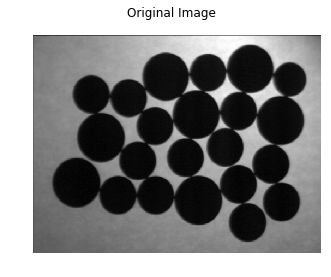

In [578]:
# This image is grayscale # 0 means read as grayscale
img = cv2.imread("P3_coins.png",0)
plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(img, cmap = 'gray')
plt.show()

There is no overlapping in the orginical image. 

In [579]:
# Otsu’s binarization thresholding
# return value and binary image
ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [580]:
# Erosion morphology removes the boundary pixels. 
# So whatever remaining, we can be sure it is coin. 
# opening (erosion followed by dilation) to remove noise
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
############# foreground ##############
############ erosion morphology operation to find the markers
sure_fg = cv2.erode(opening,kernel,iterations = 5)

In [581]:
# Dilation increases object boundary to background. 
# This way, we can make sure whatever region in background in result 
# is really a background, since boundary region is removed.
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations = 5)

In [582]:
# making markers
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers += 1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [583]:
# gray to BGR
img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# segmentation
seg = cv2.watershed(img_bgr, markers)
img_bgr[seg == -1] = [0,255,0]

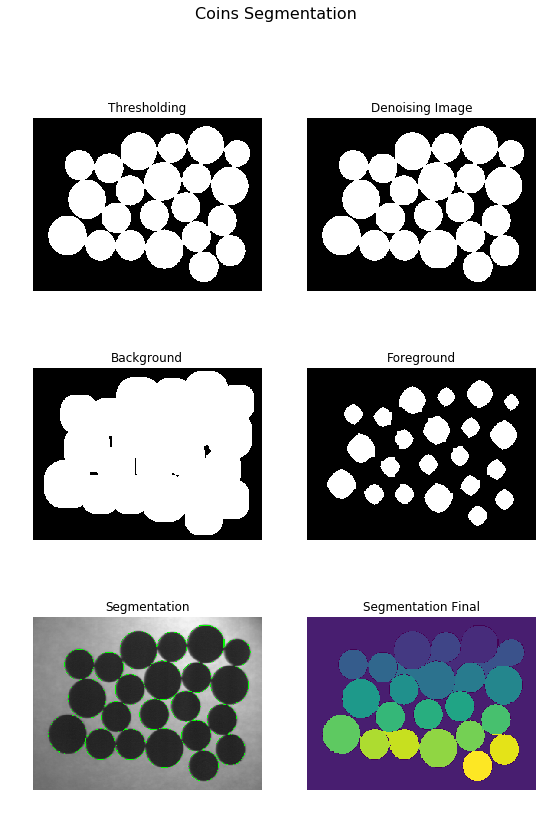

In [584]:
# final images 
fig = plt.figure(figsize=(9, 13))
ax = []
fig.suptitle("Coins Segmentation", fontsize=16)

ax.append(fig.add_subplot(3, 2, 1))
ax[-1].set_title("Thresholding")
plt.imshow(thresh, cmap = 'gray')
plt.axis("off")

ax.append(fig.add_subplot(3, 2, 2))
ax[-1].set_title("Denoising Image")
plt.imshow(opening, cmap = 'gray')
plt.axis("off")

ax.append(fig.add_subplot(3, 2, 3))
ax[-1].set_title("Background")
plt.imshow(sure_bg, cmap = 'gray')
plt.axis("off")

ax.append(fig.add_subplot(3, 2, 4))
ax[-1].set_title("Foreground")
plt.imshow(sure_fg, cmap = 'gray')
plt.axis("off")

ax.append(fig.add_subplot(3, 2, 5))
ax[-1].set_title("Segmentation")
plt.imshow(img_bgr)
plt.axis("off")

ax.append(fig.add_subplot(3, 2, 6))
ax[-1].set_title("Segmentation Final")
plt.imshow(cv2.applyColorMap(seg, cv2.COLORMAP_HSV))
plt.axis("off")

plt.show()

In [586]:
# elevation_map = sobel(img)
# segmentation = watershed(elevation_map, markers)
# segmentation = ndi.binary_fill_holes(segmentation - 1)
# labeled_coins,_ = ndi.label(segmentation)

# plt.axis("off"), plt.suptitle('Original Image')
# plt.imshow(labeled_coins)
# plt.show()

### Particles Segmentation

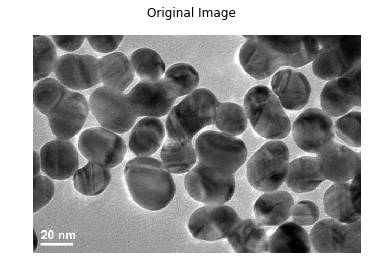

In [587]:
# This image is grayscale # 0 means read as grayscale
img = cv2.imread("P3_particles.png",0)
plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(img, cmap = 'gray')
plt.show()

There are overlappings in the orginical image. Distance transform was used to deal with the issue here.

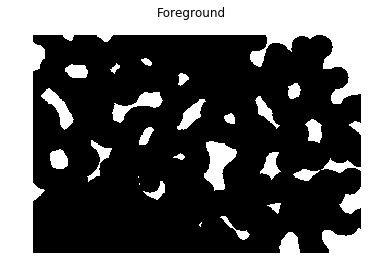

In [588]:
# return value and binary image
ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# opening (erosion followed by dilation) to remove noise
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Finding sure foreground area
# Distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)


plt.axis("off"), plt.suptitle('Foreground')
plt.imshow(sure_fg, cmap = 'gray')
plt.show()

## background
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers += 1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

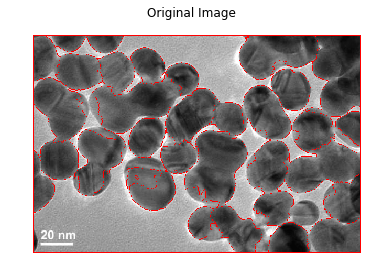

In [589]:
# gray to BGR
img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# segmentation
seg = cv2.watershed(img_bgr ,markers)
img_bgr[seg == -1] = [255,0,0]

plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(img_bgr)
plt.show()

There are overlappings and touchings in this image, which makes it difficult to segment. Thus, the distance transform method was used here to determine the internal markers. For this method, the thresholding after the distance transform determines how internal markers look like. Some overlapping objects have isolated internal markers, thus the watershed transform can seperate these objects, otherswise objects are not seperable. 

## References